Use this notebook to plot quantities onto cells.

1. Run the first 2 cells
2. Alter the paths in the __User Input__ section in cell 3 and run
3. Run cell 4 to get a llist of variables you can plot.
4. In cell 5 you can choose what variable to plot, and also change color(map)s. you can shoose if you want to lot a colormap plot or binary colours and if you want to add cell centres or alignment axes to the plot.
5. You can run this cell as many times as you want changing variavle, uncomment the savefig line and chose what you want to call the plot to save the plot in the plot directory.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import seaborn as sns

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection

from utils import fileio
from utils import geometry

In [2]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R, color):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c=color,alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres, color):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],marker ='o',markersize=2, c=color)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 5,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [5]:
#Load data file with cell quantities and Matrices C and R.
CURRENT_DIR = os.getcwd()
#output_dir=CURRENT_DIR+'/Output/'
input_dir=CURRENT_DIR+'/Input/'

output_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\DLITE_Test/Output/'

##############
#User Input
##############

#name of config file stored in the Input directory
#conf_file=input_dir+'20161130_2_GG_CadFL-GFPtub-CheHis_uf_8p6_fr251_trace_conf.csv' 

t_min=0 ## input time in minutes
pixel_size=156 ##input pixel size (probably 1024, maybe 512)
micron_size=96.95
 ## input micron size from lif or conf file.

#plot_name='test_trace_NC_hand' ##chose plot name (experiment id and frame a )

filepath=output_dir+'20240530_11_EB_LifeAct-FP_uu_0p5_SP_fr001/2024-06-06_20-16-26'

#Path to directory where Matrices are stored
mat_dir=glob(filepath+"*/Matrices")[-1]

#path to directory where data file is stored
data_dir=glob(filepath+'*/Data')[-1]
plot_dir=glob(filepath+'*/Plots')[-1]
#data file name (all or geom)
filename='20240530_11_fr001_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'

##############

#edges_name,t_min, pixel_size, micron_size = fileio.read_conf(conf_file)


edges_name='20240530_11_EB_LifeAct-FP_uu_0p5_SP_fr001'

t=t_min*60.0
#pref_area=fileio.read_pref_area(input_dir, edges_name)
pref_area=1438.1520247776568



A  = np.loadtxt(glob(mat_dir+'/*Matrix_A*.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
B  = np.loadtxt(glob(mat_dir+'/*Matrix_B*.txt')[0]) # Incidence matrix. Rows => cells; columns => edges.
C  = np.loadtxt(glob(mat_dir+'/*Matrix_C*.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
R  = np.loadtxt(glob(mat_dir+'/*Matrix_R*.txt')[0]) # Coordinates of vertices


data=pd.read_csv(os.path.join(data_dir, filename))

#make directories to output to
# if os.path.exists(output_dir+edges_name.split('_trace')[0])==False: os.mkdir(output_dir+edges_name.split('_trace')[0])

# mydir = os.path.join(output_dir+edges_name.split('_trace')[0], datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
# os.mkdir(mydir)
# plot_dir=mydir+"/Plots"
# if os.path.exists(plot_dir)==False: os.mkdir(plot_dir)

axisLength = micron_size + 0.5
#R=(R*(micron_size/pixel_size))/((pref_area)**0.5)
cell_edge_count=geometry.get_edge_count(B)
cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)


In [8]:
#These are the things that you can plot
data.columns

Index(['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'cell_perimeter_nd', 'cell_area_nd', 'cell_P_eff_nd', 'shape_parameter',
       'circularity', 'cell_edge_count', 'cell_shear', 'cell_zeta',
       'major_shape_axis_alignment_rads', 'major_stress_axis_alignment_rads'],
      dtype='object')

List of named colours to use in binary polygons:
    https://matplotlib.org/stable/gallery/color/named_colors.html 

List of pre-generated colormaps:
    https://matplotlib.org/stable/gallery/color/colormap_reference.html

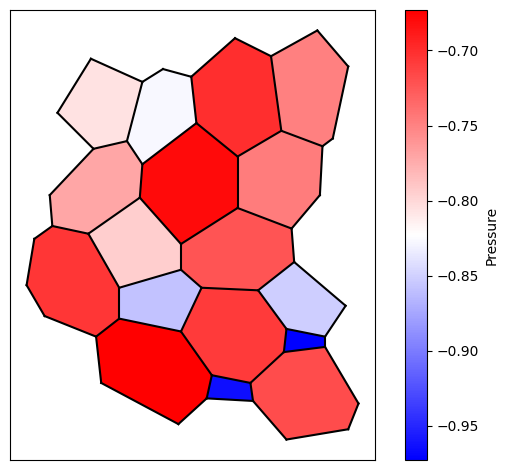

In [11]:
plot_variable=data['cell_area_nd']-1 ###Set variable to plot

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

#R=R-np.mean(R, axis=0)
## For colormap of continuous data

polys=plot_polys(C, R, cell_centres)
#polys.set_facecolor('black')
polys.set_array(plot_variable)
polys.set_cmap('bwr') ###set polygon colourmap here
polys.set_clim(np.min(plot_variable),np.max(plot_variable))
ax.add_collection(polys) 
cbar = fig.colorbar(polys, ax=ax)
cbar.ax.set_ylabel('Pressure', rotation=90) ###set colorbar label



##for discrete data colormap

# polys=plot_polys(C, R, cell_centres)
# polys.set_array(plot_variable)
# ax.add_collection(polys) 

# cmap = mpl.cm.jet ###choose colour map to discretise here

# bounds = np.arange(plot_variable.min()-0.5, plot_variable.max()+1.5, 1)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# polys.set_cmap(cmap) 
# cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              ax=ax, ticks=np.arange(plot_variable.min(), plot_variable.max()+1, 1))
# cbar.ax.set_ylabel('Number of sides', rotation=90) ###set colorbar label

## For binary colouring

# threshold=0 ###Choose threhold value
# lowcolour='blue' ###Choose low value colour here
# highcolour='red' ###Choose high value colour here
# polys_low, polys_high=plot_binary_polys(C, R, cell_centres,data['cell_P_eff_nd'], threshold)
# polys_low.set_facecolor(lowcolour) 
# ax.add_collection(polys_low)
# polys_high.set_facecolor(highcolour) 
# ax.add_collection(polys_high)




ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

## Add edges to plot 
plot_edges(A,R, 'black')

## Uncomment to plot cell centres or shape/stress alignment

#plot_cell_centres(cell_centres, 'red')

#plot_cell_id(cell_centres)

#plot_alignment_axis(cell_centres,np.asarray(data['major_stress_axis_alignment_rads']))

#plot_alignment_axis(cell_centres,np.asarray(data['major_shape_axis_alignment_rads']))


#ax.set_title("t = {}s, {}".format(t,'title text here')) ###change title

plt.gca().set_aspect('equal')
plt.tight_layout()




##uncomment to save
plt.savefig(plot_dir+'/'+edges_name+'_Pressure.png', dpi=300) ##edit filename here


In [42]:
np.min(R[:,1])

0.12127888821803394

In [11]:
np.arange(plot_variable.min(), plot_variable.max()+1, 1)

array([3., 4., 5., 6., 7., 8., 9.])

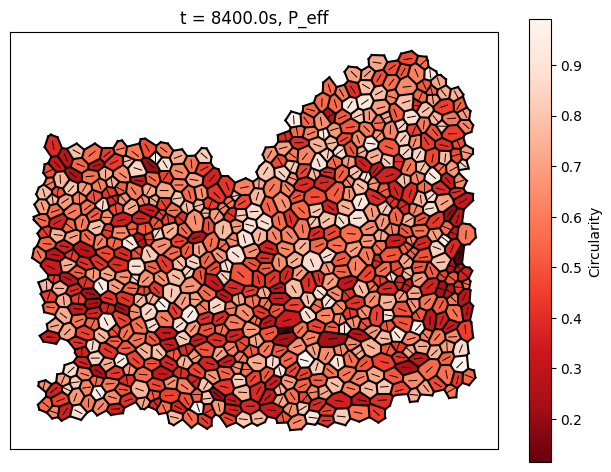

In [11]:
plot_variable=data['circularity'] ###Set variable to plot

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

## For colormap of continuous data

polys=plot_polys(C, R, cell_centres)
polys.set_array(plot_variable)
polys.set_cmap('Reds_r') ###set polygon colourmap here
ax.add_collection(polys) 
cbar = fig.colorbar(polys, ax=ax)
cbar.ax.set_ylabel('Circularity', rotation=90) ###set colorbar label

##for discrete data colormap

# polys=plot_polys(C, R, cell_centres)
# polys.set_array(plot_variable)
# ax.add_collection(polys) 

# cmap = mpl.cm.jet ###choose colour map to discretise here

# bounds = np.arange(plot_variable.min()-0.5, plot_variable.max()+1.5, 1)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# polys.set_cmap(cmap) 
# cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              ax=ax, ticks=np.arange(plot_variable.min(), plot_variable.max()+1, 1))
# cbar.ax.set_ylabel('Number of sides', rotation=90) ###set colorbar label

## For binary colouring

# threshold=0 ###Choose threhold value
# lowcolour='blue' ###Choose low value colour here
# highcolour='red' ###Choose high value colour here
# polys_low, polys_high=plot_binary_polys(C, R, cell_centres,data['cell_P_eff_nd'], threshold)
# polys_low.set_facecolor(lowcolour) 
# ax.add_collection(polys_low)
# polys_high.set_facecolor(highcolour) 
# ax.add_collection(polys_high)




ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

## Add edges to plot 
plot_edges(A,R)

## Uncomment to plot cell centres or shape/stress alignment

#plot_cell_centres(cell_centres)

plot_alignment_axis(cell_centres,np.asarray(data['major_stress_axis_alignment_rads']))

#plot_alignment_axis(cell_centres,np.asarray(data['major_shape_axis_alignment_rads']))


ax.set_title("t = {}s, {}".format(t,'P_eff')) ###change title
plt.gca().set_aspect('equal')
plt.tight_layout()

##uncomment to save
#plt.savefig(plot_dir+'/'+edges_name.split('_trace')[0]+'effective_pressure_2.png')


In [215]:
edges_name.split('_')[7]

'fr36'